In [29]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)

In [2]:
# read in october 2019 mta data
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_191026.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_191019.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_191012.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_191005.txt')

In [3]:
dataframes = ['191026', '191019', '191012', '191005']

In [4]:
def combine_dfs_add_time(dataframe_date_list):
    """
    feed in a list of turnstyle dataframes dates
    returns the combined datafrae with columns for date time and day of week
    """
    dfs = []
    for date in dataframe_date_list:
        dfs.append(pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'.format(date)))
    
        
    # concatenate the dataframes into one
    df = pd.concat(dfs, ignore_index=True)
    
    # rename the exits field
    df = df.rename(columns={'EXITS                                                               ': 'EXITS'})
    
    # create a new column that combines the day and time into one and makes it a datetime object
    df["DATE_TIME"] =  pd.to_datetime(df["DATE"] +" "+ df["TIME"])
    
    # add in a day of the week column
    df["DAY_INT"] = df["DATE_TIME"].dt.dayofweek
    
    # create a mapper to map the day of the week nubers to actual string values
    day_dict = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }
    
    # add that day of the week string column
    df["DAY_STR"] = df["DAY_INT"].map(day_dict)
    
    return df

In [5]:
combined_df = combine_dfs_add_time(dataframes)
combined_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY_INT,DAY_STR
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/19/2019,00:00:00,REGULAR,7238905,2452500,2019-10-19 00:00:00,5,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/19/2019,04:00:00,REGULAR,7238924,2452505,2019-10-19 04:00:00,5,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/19/2019,08:00:00,REGULAR,7238945,2452536,2019-10-19 08:00:00,5,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/19/2019,12:00:00,REGULAR,7239029,2452602,2019-10-19 12:00:00,5,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/19/2019,16:00:00,REGULAR,7239280,2452651,2019-10-19 16:00:00,5,Saturday


In [6]:
def add_entry_and_exit_differences(df):
    """
    Takes in the dataframe with the date time column
    returns a data frame with a entry and exit diff column
    these new columns tell us how many people exuted/entered in that time period
    """
    
    # sort the dataframe by turnstyle date
    ordered_date_df = df.sort_values(by=['STATION', 'SCP','UNIT','C/A', 'DATE_TIME'])
    
    """
    group by station, scp, unit, and c/a to get the individual counters 
    then take the difference in entries to get entry changes on each timestamp
    """
    ordered_date_df['ENTRIES_DIFF']=ordered_date_df.groupby(['STATION', 'SCP','UNIT','C/A'])['ENTRIES'].diff().fillna(0)
    
    """
    group by station, scp, unit, and c/a to get the individual counters 
    then take the difference in exits to get exit changes on each timestamp
    """
    ordered_date_df['EXIT_DIFF']=ordered_date_df.groupby(['STATION', 'SCP', 'UNIT', 'C/A'])['EXITS'].diff().fillna(0)
    
    return ordered_date_df

In [7]:
combined_df = add_entry_and_exit_differences(combined_df)
combined_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY_INT,DAY_STR,ENTRIES_DIFF,EXIT_DIFF
651330,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,00:00:00,REGULAR,15011834,16775459,2019-09-28 00:00:00,5,Saturday,0.0,0.0
651331,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,04:00:00,REGULAR,15011834,16775459,2019-09-28 04:00:00,5,Saturday,0.0,0.0
651332,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,08:00:00,REGULAR,15011834,16775461,2019-09-28 08:00:00,5,Saturday,0.0,2.0
651333,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,12:00:00,REGULAR,15011834,16775480,2019-09-28 12:00:00,5,Saturday,0.0,19.0
651334,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,16:00:00,REGULAR,15011834,16775500,2019-09-28 16:00:00,5,Saturday,0.0,20.0


In [8]:
def clean_entry_exit_values(df, max_val, min_val=0):
    """
    takes in a dataframe with the entry/exit diff columns and a max and min val for the entry diff
    returns a dataframe with the crazy values removed
    """
    
    # create mask to remove negative entries and exits or astronomically high differences
    pre_cleaning_rows = df.shape[0]
    cleaning_mask = (df["ENTRIES_DIFF"]>=min_val) & \
                    (df["EXIT_DIFF"]>=min_val) & \
                    (df["ENTRIES_DIFF"]<max_val) & \
                    (df["EXIT_DIFF"]<max_val)
    
    df = df[cleaning_mask]
    post_cleaning_rows = df.shape[0]
    print("You removed {} rows in the cleaning".format(pre_cleaning_rows-post_cleaning_rows))
    return df

In [9]:
combined_df=clean_entry_exit_values(combined_df, 100000)
combined_df.head()

You removed 9654 rows in the cleaning


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY_INT,DAY_STR,ENTRIES_DIFF,EXIT_DIFF
651330,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,00:00:00,REGULAR,15011834,16775459,2019-09-28 00:00:00,5,Saturday,0.0,0.0
651331,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,04:00:00,REGULAR,15011834,16775459,2019-09-28 04:00:00,5,Saturday,0.0,0.0
651332,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,08:00:00,REGULAR,15011834,16775461,2019-09-28 08:00:00,5,Saturday,0.0,2.0
651333,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,12:00:00,REGULAR,15011834,16775480,2019-09-28 12:00:00,5,Saturday,0.0,19.0
651334,H007,R248,00-00-00,1 AV,L,BMT,09/28/2019,16:00:00,REGULAR,15011834,16775500,2019-09-28 16:00:00,5,Saturday,0.0,20.0


In [10]:
def totals_combined_per_station(df):
    
    """
    takes in a dataframe with the entry/exit diff columns
    returns a dataframe with rows of avg entries, exits, and cobined for each station in desc order
    """
    
    # show the total entries and exits, it looks much better
    entries_exit_totals = df.groupby(["STATION"])[["ENTRIES_DIFF", "EXIT_DIFF"]].sum()
    
    # cobine the entries and exits and sort to get the most popuklar stations
    entries_exit_totals["COMBINED"] = entries_exit_totals["ENTRIES_DIFF"] + entries_exit_totals["EXIT_DIFF"]
    entries_exit_totals = entries_exit_totals.sort_values(by=["COMBINED"], ascending=False)
    
    return entries_exit_totals

In [11]:
daily_totals = totals_combined_per_station(combined_df)
daily_totals

,ENTRIES_DIFF,EXIT_DIFF,COMBINED
STATION,,,
34 ST-PENN STA,4105896.0,3800855.0,7906751.0
GRD CNTRL-42 ST,3423804.0,3307108.0,6730912.0
34 ST-HERALD SQ,2899040.0,2785237.0,5684277.0
23 ST,2902818.0,2182637.0,5085455.0
14 ST-UNION SQ,2539897.0,2403720.0,4943617.0
TIMES SQ-42 ST,2477572.0,2409297.0,4886869.0
FULTON ST,2352961.0,2088237.0,4441198.0
42 ST-PORT AUTH,2281313.0,2036327.0,4317640.0
86 ST,2112051.0,2025804.0,4137855.0


In [12]:
def avg_combined_per_station(df):

    """
    takes in a dataframe with the entry/exit diff columns
    returns a dataframe with rows of total entries, exits, and cobined for each station in desc order
    """

    # show the total entries and exits, it looks much better
    entries_exit_totals = df.groupby(["STATION", "DATE"])[["ENTRIES_DIFF", "EXIT_DIFF"]].sum()
    entries_exit_avg = entries_exit_totals.groupby(["STATION"])[["ENTRIES_DIFF", "EXIT_DIFF"]].mean()

    # cobine the entries and exits and sort to get the most popuklar stations
    entries_exit_avg["COMBINED"] = entries_exit_avg["ENTRIES_DIFF"] + entries_exit_avg["EXIT_DIFF"]
    entries_exit_avg = entries_exit_avg.sort_values(by=["COMBINED"], ascending=False)

    return entries_exit_avg

In [13]:
daily_avgs = avg_combined_per_station(combined_df)
daily_avgs

,ENTRIES_DIFF,EXIT_DIFF,COMBINED
STATION,,,
34 ST-PENN STA,146639.142857,135744.821429,282383.964286
GRD CNTRL-42 ST,122278.714286,118111.000000,240389.714286
34 ST-HERALD SQ,103537.142857,99472.750000,203009.892857
23 ST,103672.071429,77951.321429,181623.392857
14 ST-UNION SQ,90710.607143,85847.142857,176557.750000
TIMES SQ-42 ST,88484.714286,86046.321429,174531.035714
FULTON ST,84034.321429,74579.892857,158614.214286
42 ST-PORT AUTH,81475.464286,72725.964286,154201.428571
86 ST,75430.392857,72350.142857,147780.535714


In [49]:
def avg_per_day_of_week(df):
    """
    takes in a dataframe with the entry/exit diff columns
    returns a dataframe with rows of total entries, exits, and cobined for the avg traffic 
    on each DAY OF WEEK for each station
    
    i.e. Station A on Monday
    """
    
    # return the avg usage per day of week per station on each day
    total_daily_per_station = df.groupby(['STATION', 'DATE','DAY_INT', 'DAY_STR',])["ENTRIES_DIFF", "EXIT_DIFF"].sum()

    # average out the traffic at each station grouped by day of the week 
    avg_daily_per_station = total_daily_per_station.groupby(["STATION","DAY_INT", "DAY_STR"])["ENTRIES_DIFF", "EXIT_DIFF"].mean()

    # cobine the entries and exits and sort to get the most popuklar days at what stations 
    avg_daily_per_station["COMBINED"] = avg_daily_per_station["ENTRIES_DIFF"] + avg_daily_per_station["EXIT_DIFF"]
    avg_daily_per_station.sort_values(by=["COMBINED"], ascending=False)
    
    return avg_daily_per_station


In [51]:
avg_per_day = avg_per_day_of_week(combined_df)
avg_per_day.reset_index().head()

,STATION,DAY_INT,DAY_STR,ENTRIES_DIFF,EXIT_DIFF,COMBINED
0,1 AV,0,Monday,14863.50,16580.00,31443.50
1,1 AV,1,Tuesday,17637.00,19491.25,37128.25
2,1 AV,2,Wednesday,18032.00,20379.50,38411.50
3,1 AV,3,Thursday,19429.75,20879.50,40309.25
4,1 AV,4,Friday,19699.75,21614.25,41314.00


In [52]:
def avg_per_day_of_week_and_time(df):
    """
    takes in a dataframe with the entry/exit diff columns
    returns a dataframe with rows of total entries, exits, and cobined for the avg traffic 
    on each DAY OF WEEK and TIME SLOT for each station
    
    i.e. Station A on Monday between 2-6 pm
    """
    
    # get the total traffic for each station at each hour of each day
    total_hourly_per_station = df.groupby(['STATION', 'DATE', 'DAY_INT', 'DAY_STR' ,'TIME'])["ENTRIES_DIFF", "EXIT_DIFF"].sum()

    # average out the traffic at each station grouped by day of the week and time slot
    avg_hourly_per_station = total_hourly_per_station.groupby(["STATION", 'DAY_INT', 'DAY_STR' ,"TIME"])["ENTRIES_DIFF", "EXIT_DIFF"].mean()

    # cobine the entries and exits and sort to get the most popular days and times at each stations 
    avg_hourly_per_station["COMBINED"] = avg_hourly_per_station["ENTRIES_DIFF"] + avg_hourly_per_station["EXIT_DIFF"]
    avg_hourly_per_station.sort_values(by=["COMBINED"], ascending=False).head(50)
    
    return avg_hourly_per_station

In [53]:
avg_per_day_of_week_and_time = avg_per_day_of_week_and_time(combined_df)
avg_per_day_of_week_and_time.head()

ENTRIES_DIFF  EXIT_DIFF  COMBINED
STATION DAY_INT DAY_STR TIME                                       
1 AV    0       Monday  00:00:00        723.50     751.00   1474.50
                        04:00:00        127.50     130.25    257.75
                        08:00:00       1128.00    2530.00   3658.00
                        12:00:00       4027.50    4294.25   8321.75
                        16:00:00       3606.75    3387.00   6993.75

In [44]:
def create_interested_colored_bar_graph(df, num_stations):
    
    """
    Takes in a dataframe that has combined data and total nscore data
    outputs a bar plot with the bars colored by score
    """
    
    color_mapper = {
        "7":'g',
        "6":'b',
        "5":'y',
        "4":'y',
        "3":'orange',
        "2":'r',
        "1":'r',
        "0":'r',
    }
    
    df["color"] = df["total score"].astype(str).map(color_mapper)
    
    return(df.head(num_stations).plot.bar(x='STATION', y='COMBINED', color=df["color"], figsize=(10,5)))
    plt.xticks(rotation=90);

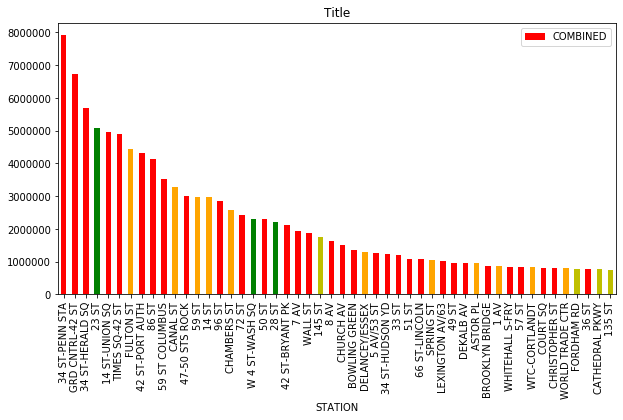

In [48]:
highlighted_stations = pd.read_csv('important_stations.csv')
highlighted_stations.drop(['Unnamed: 0'], axis=1, inplace=True, errors='ignore')
highlighted_stations.rename(columns={'stations': 'STATION'}, inplace=True)
highlighted_stations.head()
totals_with_score = pd.merge(daily_totals, highlighted_stations, on='STATION')
create_interested_colored_bar_graph(totals_with_score, 50)
plt.title("Title");

AttributeError: 'AxesSubplot' object has no attribute 'show'